In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
from datetime import date, timedelta, datetime
from dateutil.relativedelta import relativedelta
import cftime

### 123 kgN fertilizer experiment

In [33]:
fert_amount = "123"
case_clarion = "MESOCOSM_Clarion_" + fert_amount + "kgN"
case_webster = "MESOCOSM_Webster_" + fert_amount + "kgN"
path_clarion = "/glade/scratch/jinmuluo/archive/" + case_clarion + "/lnd/hist/" 
path_webster = "/glade/scratch/jinmuluo/archive/" + case_webster + "/lnd/hist/" 
start_date = date(2022, 1, 1)
end_date = date(2022, 12, 1)
NO_LEAP = True
delta_days = (end_date - start_date).days

NInput = ['MANURE_N_GRZ', 'MANURE_N_BARNS', 'FERT_N_APP', 'NDEP_TO_SMINN', 'NFIX', 
          'FFIX_TO_SMINN', 'FERT_TO_SMINN', 'NITRATE_N_TO_SMINN', 'F_CANOPY_TO_SOIL']
MID_TERM_FAN = ["FERT_NO3_TO_SOIL", "MANURE_NO3_TO_SOIL"]
RUNOFF = ["MANURE_NITRATE_RUNOFF", 'FERT_NITRATE_RUNOFF', "CANOPY_TO_SOIL","FERT_NITRATE_TO_SOIL", "MANURE_NITRATE_TO_SOIL",
          'SMIN_NO3_RUNOFF', 'SMIN_NO3_LEACHED']
GAS = ["N2O_DENITRIFY_TOTAL", "N2O_NITRIFY_TOTAL", "NOx_DENITRIFY_TOTAL", "NOx_NITRIFY_TOTAL", "N2_TOTAL", 'NH3_TOTAL',
       'F_N2O_NIT', 'F_NOx_NIT', 'F_N2O_DENIT', 'F_NOx_DENIT', 'F_N2_DENIT']
POOLS = ["NITRATE_G1", "NITRATE_G2", "NITRATE_G3", "NITRATE_S0", 
         "NITRATE_S1", "NITRATE_S2", "NITRATE_S3", "NITRATE_F1", "NITRATE_F2",  "NITRATE_F3",  "NITRATE_F4"]
Others = ["FAN_TOTN", "NITRATE_TOTN",'SMINN', 'SMINN_vr', 'SMIN_NH4_vr', 'SMIN_NO3_vr', 'QOVER', 'H2OSOI', 'TSOI_10CM',
         'SMINN_TO_PLANT_FUN_NO3', 'SMINN_TO_PLANT_FUN_NH4', 'F_NIT', 'F_DENIT']

CLM_Clarion = []
CLM_Webster = []

for i in range(delta_days):
    currdate = start_date + relativedelta(days=i)
    currdate = currdate.strftime('%Y-%m-%d')
    if NO_LEAP and currdate[5:7]== "02" and currdate[8:10] == "29":
        print('Skip the leap date:', currdate)
        continue
    CLM_Clarion.append(path_clarion + case_clarion + ".clm2." + "h1" + "." + currdate +"-00000.nc")
    CLM_Webster.append(path_webster + case_webster + ".clm2." + "h1" + "." + currdate +"-00000.nc")

In [53]:
def preprocess(ds, fields= GAS + Others + RUNOFF):
    return(ds[fields])

dsCLM_Clarion = xr.open_mfdataset(CLM_Clarion, decode_times=True, preprocess=preprocess)

def preprocess(ds, fields=GAS+Others+RUNOFF):
    return(ds[fields])

dsCLM_Webster = xr.open_mfdataset(CLM_Webster, decode_times=True, preprocess=preprocess)

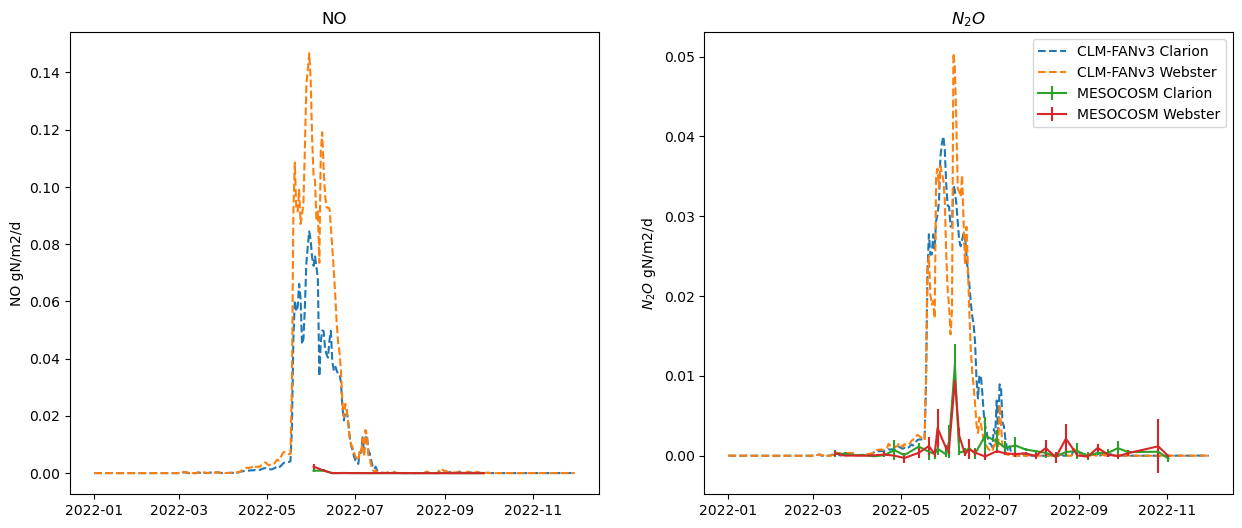

In [64]:
# Read the measurements
p2 = "/glade/scratch/jinmuluo/MESOCOSM_fluxtower_BOOI4/measurements/"
dsNO = pd.read_csv(p2+'mesocosm_NOx_combined_2022.csv')
dsNO['date'] = pd.to_datetime(dsNO['date']) + pd.Timedelta(hours=0, minutes=0, seconds=0)
dsNO.set_index(['soil', 'N_rate_kg_ha', 'Block', 'date'], inplace=True)
dsNO = dsNO.sort_index()
dsNO['Mean_NO_flux_gN/m2/d'] = dsNO['Mean_NO_flux_nmol_m2_s']*1e-9*30*24*3600/14
dsN2O = pd.read_csv(p2+'mesocosm_ghg_flux_data_2022.csv')
dsN2O['date'] = pd.to_datetime(dsN2O['date']) + pd.Timedelta(hours=0, minutes=0, seconds=0)
dsN2O.set_index(['soil', 'N_rate_num', 'block', 'date'], inplace=True)
dsN2O = dsN2O.sort_index()

mean_dsNO_cla = dsNO.loc[('Clarion', 123), 'Mean_NO_flux_gN/m2/d'].groupby(level='date').mean()
std_dsNO_cla = dsNO.loc[('Clarion', 123), 'Mean_NO_flux_gN/m2/d'].groupby(level='date').std()
mean_dsNO_web = dsNO.loc[('Webster', 123), 'Mean_NO_flux_gN/m2/d'].groupby(level='date').mean()
std_dsNO_web = dsNO.loc[('Webster', 123), 'Mean_NO_flux_gN/m2/d'].groupby(level='date').std()
mean_dsN2O_cla = dsN2O.loc[('Clarion', 123), 'nitrous_oxide_N_flux_g_m2_d'].groupby(level='date').mean()
std_dsN2O_cla = dsN2O.loc[('Clarion', 123), 'nitrous_oxide_N_flux_g_m2_d'].groupby(level='date').std()
mean_dsN2O_web = dsN2O.loc[('Webster', 123), 'nitrous_oxide_N_flux_g_m2_d'].groupby(level='date').mean()
std_dsN2O_web = dsN2O.loc[('Webster', 123), 'nitrous_oxide_N_flux_g_m2_d'].groupby(level='date').std()
no_time = mean_dsNO_cla.index.values
n2o_time = mean_dsN2O_cla.index.values


# Read the model simulations
NO_Clarion = (dsCLM_Clarion.NOx_NITRIFY_TOTAL + dsCLM_Clarion.NOx_DENITRIFY_TOTAL + dsCLM_Clarion.F_NOx_NIT + dsCLM_Clarion.F_NOx_DENIT)
NO_Clarion = NO_Clarion.resample(time='D').mean()*24*3600
NO_Clarion.attrs['units'] = "gN/m2/d"
NO_Clarion['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in NO_Clarion.time]
NO_Webster = (dsCLM_Webster.NOx_NITRIFY_TOTAL + dsCLM_Webster.NOx_DENITRIFY_TOTAL + dsCLM_Webster.F_NOx_NIT + dsCLM_Webster.F_NOx_DENIT)
NO_Webster = NO_Webster.resample(time='D').mean()*24*3600
NO_Webster.attrs['units'] = "gN/m2/d"
NO_Webster['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in NO_Webster.time]

N2O_Clarion = (dsCLM_Clarion.N2O_NITRIFY_TOTAL + dsCLM_Clarion.F_N2O_NIT + dsCLM_Clarion.N2O_DENITRIFY_TOTAL+ dsCLM_Clarion.F_N2O_DENIT)
N2O_Clarion = N2O_Clarion.resample(time='D').mean()*24*3600
N2O_Clarion.attrs['units'] = "gN/m2/d"
N2O_Clarion['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in N2O_Clarion.time]
N2O_Webster = (dsCLM_Webster.N2O_NITRIFY_TOTAL + dsCLM_Webster.F_N2O_NIT + dsCLM_Webster.N2O_DENITRIFY_TOTAL+ dsCLM_Webster.F_N2O_DENIT)
N2O_Webster = N2O_Webster.resample(time='D').mean()*24*3600
N2O_Webster.attrs['units'] = "gN/m2/d"
N2O_Webster['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in N2O_Webster.time]

# Plot the graph
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax[0].plot(NO_Clarion.time, NO_Clarion.values, linestyle='--', label='CLM-FANv3 Clarion')
ax[0].plot(NO_Webster.time, NO_Webster.values, linestyle='--', label='CLM-FANv3 Webster')
ax[0].errorbar(no_time, mean_dsNO_cla.values, yerr=std_dsNO_cla.values, label='MESOCOSM Clarion')
ax[0].errorbar(no_time, mean_dsNO_web.values, yerr=std_dsNO_web.values, label='MESOCOSM Webster')
ax[0].set_title("NO")
ax[0].set_ylabel("NO gN/m2/d")

ax[1].plot(N2O_Clarion.time, N2O_Clarion.values, linestyle='--', label='CLM-FANv3 Clarion')
ax[1].plot(N2O_Webster.time, N2O_Webster.values, linestyle='--', label='CLM-FANv3 Webster')
ax[1].errorbar(n2o_time, mean_dsN2O_cla.values, yerr=std_dsN2O_cla.values, label='MESOCOSM Clarion')
ax[1].errorbar(n2o_time, mean_dsN2O_web.values, yerr=std_dsN2O_web.values, label='MESOCOSM Webster')
ax[1].set_title("$N_2O$")
ax[1].set_ylabel("$N_2O$ gN/m2/d")
ax[1].legend()

fig.savefig("graphs/Ngas_123kgN.jpg", dpi=300)
plt.show()

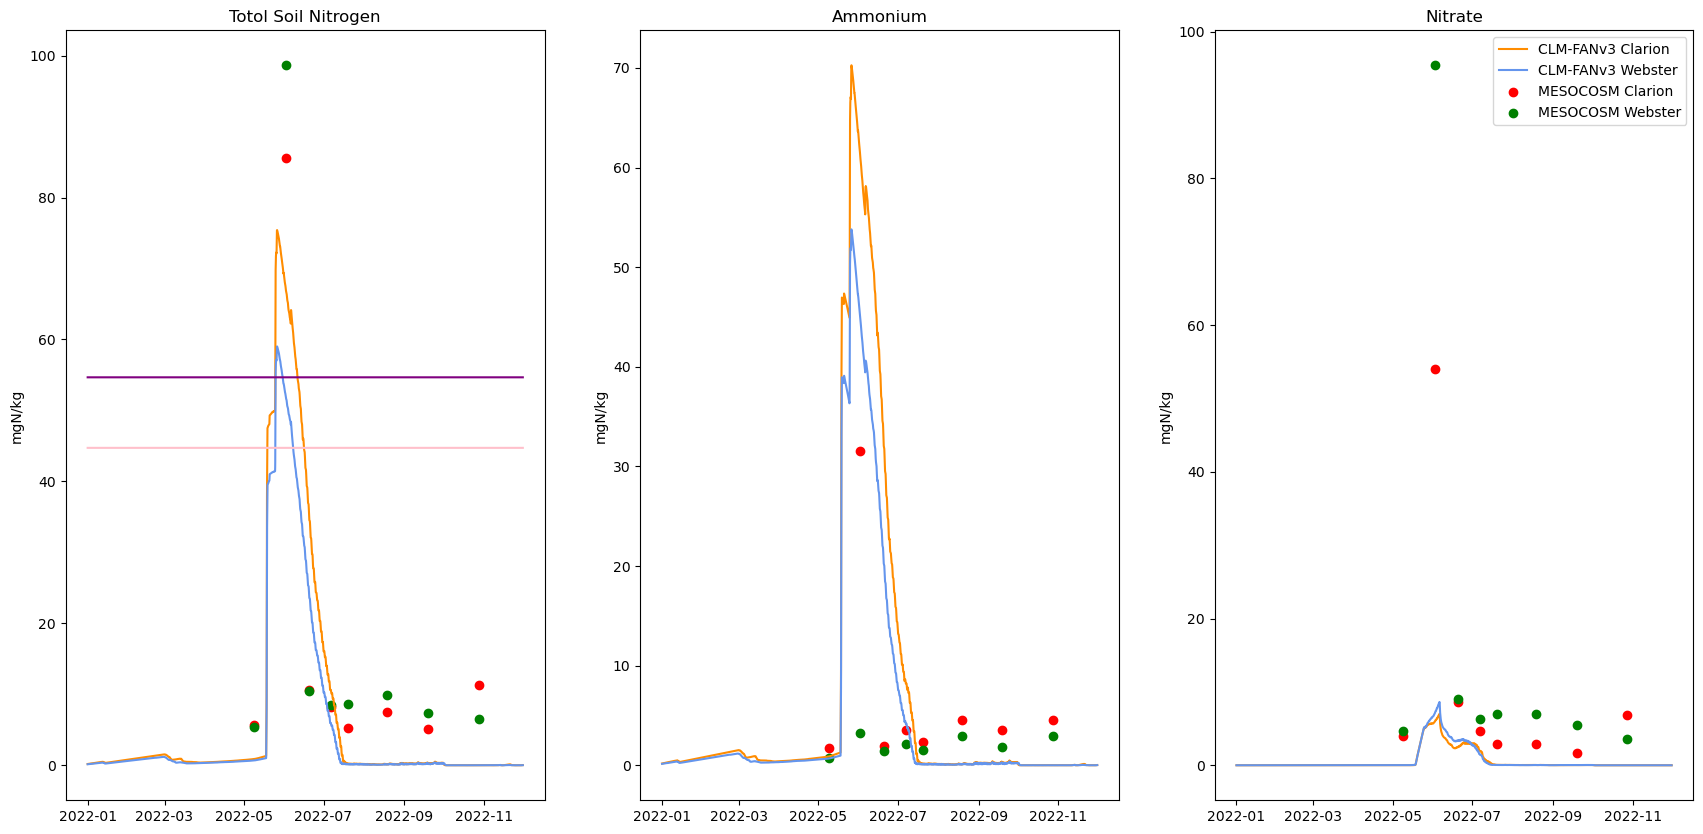

In [65]:
# Read the measurement
dsMESOCOSM = pd.read_csv("/glade/scratch/jinmuluo/MESOCOSM_fluxtower_BOOI4/measurements/mescocosm_extracted_soil_nitrogen_2022.csv")
dsMESOCOSM['date'] = ['20' + str(t) for t in dsMESOCOSM['date'].values]
dsMESOCOSM['date'] = pd.to_datetime(dsMESOCOSM['date']) + pd.Timedelta(hours=0, minutes=0, seconds=0)
dsMESOCOSM['soil_sminn'] = dsMESOCOSM['soil_nitrate_mgN_kg'] + dsMESOCOSM['soil_ammonium_mgN_kg']
dsMESOCOSM.set_index(['soil', 'N_rate_kg_ha', 'block', 'date'], inplace=True)
dsMESOCOSM = dsMESOCOSM.sort_index()

sminn_cla = dsMESOCOSM.loc[('Clarion', 123), 'soil_sminn'].groupby(level='date').mean()
sminn_web = dsMESOCOSM.loc[('Webster', 123), 'soil_sminn'].groupby(level='date').mean()
nh4_cla = dsMESOCOSM.loc[('Clarion', 123), 'soil_ammonium_mgN_kg'].groupby(level='date').mean()
nh4_web = dsMESOCOSM.loc[('Webster', 123), 'soil_ammonium_mgN_kg'].groupby(level='date').mean()
no3_cla = dsMESOCOSM.loc[('Clarion', 123), 'soil_nitrate_mgN_kg'].groupby(level='date').mean()
no3_web = dsMESOCOSM.loc[('Webster', 123), 'soil_nitrate_mgN_kg'].groupby(level='date').mean()
plot_time = no3_web.index.values

# Read the CLM simulation results
sminn_Clarion = dsCLM_Clarion['SMINN_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')
sminn_Webster = dsCLM_Webster['SMINN_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')
## gN/m3 to mgN/kg at the top 9 cm soil, soil bulk density from Steven Hall, CLM uses soil density 2650
sminn_Clarion = sminn_Clarion*1000/1125
sminn_Webster = sminn_Webster*1000/1375
sminn_Clarion['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in sminn_Clarion.time]
sminn_Webster['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in sminn_Webster.time]
## gN/m2 to mgN/kg, fertilization depth is around top 20cm
fert_conc_cla = 12.3*1000/0.2/1125
fert_conc_web = 12.3*1000/0.2/1375

dsCLM_Clarion['SMIN_NH4_vr'].sel(levsoi=0.01).values = dsCLM_Clarion['SMIN_NH4_vr'].sel(levsoi=0.01).values + dsCLM_Clarion["FAN_TOTN"].values - dsCLM_Clarion["NITRATE_TOTN"].values
dsCLM_Webster['SMIN_NH4_vr'].sel(levsoi=0.01).values = dsCLM_Webster['SMIN_NH4_vr'].sel(levsoi=0.01).values + dsCLM_Webster["FAN_TOTN"].values - dsCLM_Webster["NITRATE_TOTN"].values
nh4_Clarion = dsCLM_Clarion['SMIN_NH4_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')
nh4_Webster = dsCLM_Webster['SMIN_NH4_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')
nh4_Clarion = nh4_Clarion*1000/1125
nh4_Webster = nh4_Webster*1000/1375
nh4_Clarion['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in nh4_Clarion.time]
nh4_Webster['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in nh4_Webster.time]

dsCLM_Clarion['SMIN_NO3_vr'].sel(levsoi=0.01).values = dsCLM_Clarion['SMIN_NO3_vr'].sel(levsoi=0.01).values + dsCLM_Clarion["NITRATE_TOTN"].values   
dsCLM_Webster['SMIN_NO3_vr'].sel(levsoi=0.01).values = dsCLM_Webster['SMIN_NO3_vr'].sel(levsoi=0.01).values + dsCLM_Webster["NITRATE_TOTN"].values
no3_Clarion = dsCLM_Clarion['SMIN_NO3_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')
no3_Webster = dsCLM_Webster['SMIN_NO3_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')
no3_Clarion = no3_Clarion*1000/1125
no3_Webster = no3_Webster*1000/1375
no3_Clarion['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in no3_Clarion.time]
no3_Webster['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in no3_Webster.time]

# graph
fig, ax = plt.subplots(1, 3, figsize=(21, 10))
ax[0].plot(sminn_Clarion.time, sminn_Clarion.values, label='CLM-FANv3 Clarion', color='darkorange')
ax[0].plot(sminn_Webster.time, sminn_Webster.values, label='CLM-FANv3 Webster', color='cornflowerblue')
ax[0].plot(sminn_Clarion['time'], np.ones(len(sminn_Clarion['time']))*fert_conc_cla, color='purple')
ax[0].plot(sminn_Clarion['time'], np.ones(len(sminn_Clarion['time']))*fert_conc_web, color='pink')
ax[0].scatter(plot_time, sminn_cla.values, label='MESOCOSM Clarion', color='red')
ax[0].scatter(plot_time, sminn_web.values, label='MESOCOSM Webster', color='green')
ax[0].set_title("Totol Soil Nitrogen")
ax[0].set_ylabel("mgN/kg")

ax[1].plot(sminn_Clarion.time, nh4_Clarion.values, label='CLM-FANv3 Clarion', color='darkorange')
ax[1].plot(sminn_Webster.time, nh4_Webster.values, label='CLM-FANv3 Webster', color='cornflowerblue')
ax[1].scatter(plot_time, nh4_cla.values, label='MESOCOSM Clarion', color='red')
ax[1].scatter(plot_time, nh4_web.values, label='MESOCOSM Webster', color='green')
ax[1].set_title("Ammonium")
ax[1].set_ylabel("mgN/kg")

ax[2].plot(sminn_Clarion.time, no3_Clarion.values, label='CLM-FANv3 Clarion', color='darkorange')
ax[2].plot(sminn_Webster.time, no3_Webster.values, label='CLM-FANv3 Webster', color='cornflowerblue')
ax[2].scatter(plot_time, no3_cla.values, label='MESOCOSM Clarion', color='red')
ax[2].scatter(plot_time, no3_web.values, label='MESOCOSM Webster', color='green')
ax[2].set_title("Nitrate")
ax[2].set_ylabel("mgN/kg")

plt.legend(loc="upper right")
fig.savefig("graphs/Nconc_123kgN.jpg", dpi=300)
plt.show()

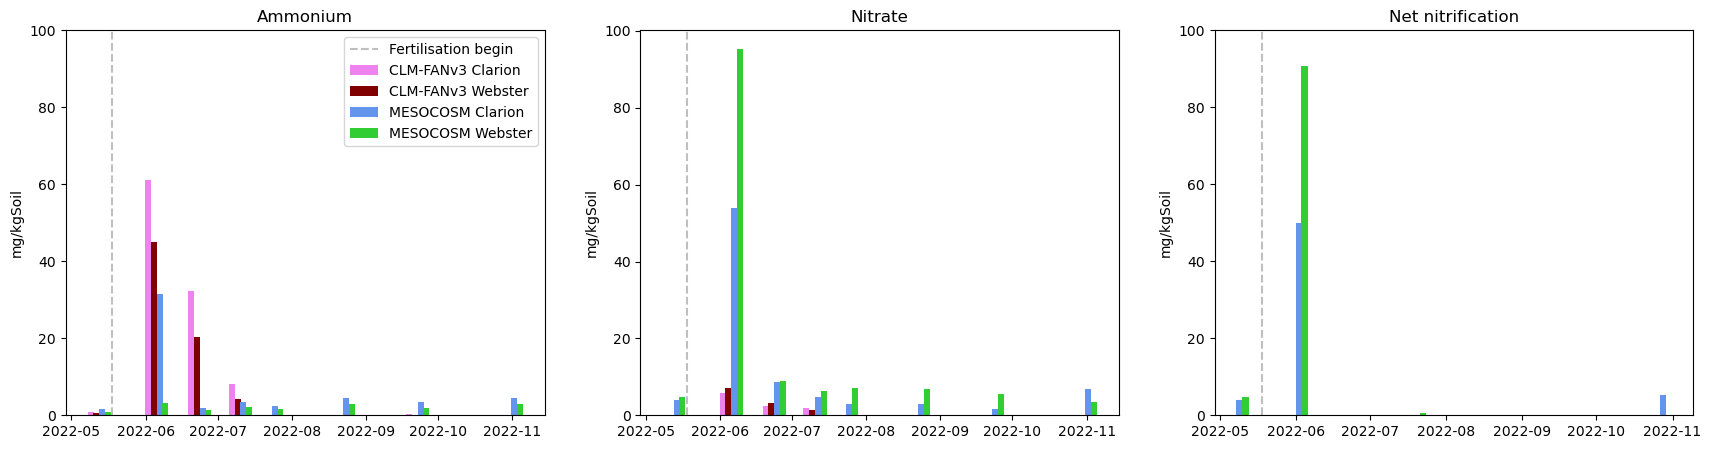

In [66]:
#
fert_date = cftime.date2num(cftime.DatetimeGregorian(2022, 5, 18, 0, 0, 0), "days since 1970-01-01")
t_term = []
for t in plot_time:
    term = pd.to_datetime(t)
    x = cftime.DatetimeNoLeap(term.year, term.month, term.day)
    t_term.append(cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian'))
    
nh4_cla_bar = np.squeeze(nh4_Clarion.sel(time=t_term, method='nearest').values)
nh4_web_bar = np.squeeze(nh4_Webster.sel(time=t_term, method='nearest').values)
no3_cla_bar = np.squeeze(no3_Clarion.sel(time=t_term, method='nearest').values)
no3_web_bar = np.squeeze(no3_Webster.sel(time=t_term, method='nearest').values)
deni_cla = np.zeros(len(no3_cla.values))
deni_web = np.zeros(len(no3_web.values))

for i in range(len(no3_web.values)):
    if i == 0:
        deni_cla[i] = no3_cla.values[i]
        deni_web[i] = no3_web.values[i]
    else:
        deni_cla[i] = no3_cla.values[i] - no3_cla.values[i-1]
        deni_web[i] = no3_web.values[i] - no3_web.values[i-1]
        if deni_cla[i] < 0:
            deni_cla[i] = 0
        if deni_web[i] < 0:
            deni_web[i]=0

    
# Graph
fig, ax = plt.subplots(1, 3, figsize=(21, 5))
drift = (plot_time[1] - plot_time[0])/10

ax[0].bar(plot_time, nh4_cla_bar, width=2.5, color='violet', label='CLM-FANv3 Clarion')
ax[0].bar(plot_time + drift, nh4_web_bar, width=2.5, color='maroon', label='CLM-FANv3 Webster')
ax[0].bar(plot_time + 2*drift, nh4_cla.values, width=2.5, color='cornflowerblue', label='MESOCOSM Clarion')
ax[0].bar(plot_time + 3*drift, nh4_web.values, width=2.5, color='limegreen', label='MESOCOSM Webster')
ax[0].axvline(x=fert_date, ymin=0, ymax=100,ls='--', color='grey', alpha=0.5, label='Fertilisation begin')
ax[0].set_ylim(0, 100)
ax[0].set_ylabel('mg/kgSoil')
ax[0].set_title('Ammonium')
ax[0].legend()

ax[1].bar(plot_time, no3_cla_bar, width=2.5, color='violet', label='CLM-FANv3 Clarion')
ax[1].bar(plot_time + drift, no3_web_bar, width=2.5, color='maroon', label='CLM-FANv3 Webster')
ax[1].bar(plot_time + 2*drift, no3_cla.values, width=2.5, color='cornflowerblue', label='MESOCOSM Clarion')
ax[1].bar(plot_time + 3*drift, no3_web.values, width=2.5, color='limegreen', label='MESOCOSM Webster')
ax[1].axvline(x=fert_date, ymin=0, ymax=100,ls='--', color='grey', alpha=0.5, label='Fertilisation begin')
ax[1].set_ylabel('mg/kgSoil')
ax[1].set_title('Nitrate')

ax[2].bar(plot_time, deni_cla, width=2.5, color='cornflowerblue', label='MESOCOSM Clarion')
ax[2].bar(plot_time + drift, deni_web, width=2.5, color='limegreen', label='MESOCOSM Webster')
ax[2].axvline(x=fert_date, ymin=0, ymax=100,ls='--', color='grey', alpha=0.5, label='Fertilisation begin')
ax[2].set_ylabel('mg/kgSoil')
ax[2].set_ylim(0, 100)
ax[2].set_title('Net nitrification')
fig.savefig("graphs/Nconc_bar_123kgN.jpg", dpi=300)
plt.show()

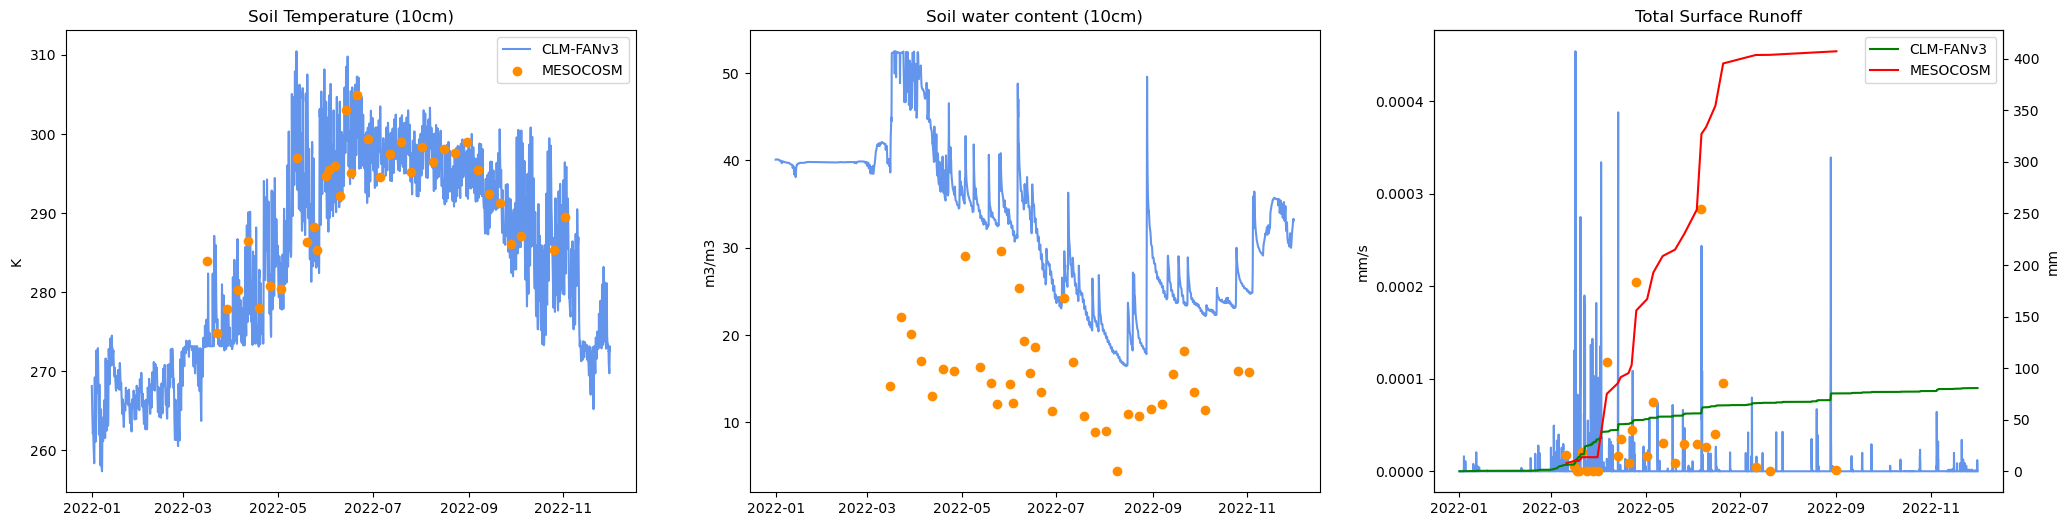

In [67]:
# Read the measurements
dsSoil = pd.read_csv("/glade/scratch/jinmuluo/MESOCOSM_fluxtower_BOOI4/measurements/mesocosm_ghg_flux_data_2022.csv")
dsSoil['date'] = pd.to_datetime(dsSoil['date']) + pd.Timedelta(hours=0, minutes=0, seconds=0)
dsSoil['air_temperature_K'] = dsSoil['air_temperature_C'] + 273.15
dsSoil.set_index(['soil', 'N_rate_num', 'block', 'date'], inplace=True)
dsSoil = dsSoil.sort_index()

dsWater = pd.read_csv("/glade/scratch/jinmuluo/MESOCOSM_fluxtower_BOOI4/measurements/mesocosm_drainage_water_quantity_N_2023.csv")
dsWater['date'] = pd.to_datetime(dsWater['date']) + pd.Timedelta(hours=0, minutes=0, seconds=0)
## Sampling period starts from the last sampling. 
dsWater['instantaneous_drainage_mm_s'] = dsWater['instantaneous_drainage_cm']*10/dsWater['st_days']/24/3600
dsWater['cumulative_drainage_mm'] = dsWater['cumulative_drainage_cm']*10
dsWater.set_index(['soil', 'N_rate_kg_ha', 'block', 'date'], inplace=True)
dsWater = dsWater.sort_index()

air_tem = dsSoil.loc[('Clarion', 123), 'air_temperature_K'].groupby('date').mean()
h2o_meso = dsSoil.loc[('Clarion', 123), 'soil_moisture_volume_percent'].groupby('date').mean()
runoff_meso = dsWater.loc[('Clarion', 123), 'instantaneous_drainage_mm_s'].groupby('date').mean()
runoff_meso_cum = dsWater.loc[('Clarion', 123), 'cumulative_drainage_mm'].groupby('date').mean()

# CLM simulations
tem_sim = dsCLM_Clarion['TSOI_10CM']
tem_sim['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in tem_sim.time]
h2o_sim = dsCLM_Clarion['H2OSOI'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')*100
h2o_sim['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in h2o_sim.time]
runoff_sim = dsCLM_Clarion['QOVER']
runoff_sim['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in runoff_sim.time]
## Hourly resolution, from mm/s to mm
runoff_sim_cum = (dsCLM_Clarion['QOVER']*3600).cumsum()

# Graph
fig, ax = plt.subplots(1, 3, figsize=(25, 6))
ax[0].plot(tem_sim.time, tem_sim.values, label='CLM-FANv3', color='cornflowerblue', zorder=1)
ax[0].scatter(air_tem.index.values, air_tem, label='MESOCOSM', color='darkorange', zorder=2)
ax[0].set_title("Soil Temperature (10cm)")
ax[0].set_ylabel("K")
ax[0].legend()

ax[1].plot(h2o_sim.time, h2o_sim.values, label='CLM-FANv3', color='cornflowerblue', zorder=1)
ax[1].scatter(h2o_meso.index.values, h2o_meso.values, label='MESOCOSM', color='darkorange', zorder=2)
ax[1].set_title("Soil water content (10cm)")
ax[1].set_ylabel("m3/m3")

ax2 = ax[2].twinx()
ax[2].plot(runoff_sim.time, runoff_sim.values, label='CLM-FANv3', color='cornflowerblue', zorder=1)
ax[2].scatter(runoff_meso.index.values, runoff_meso.values, label='MESOCOSM', color='darkorange', zorder=2)
ax[2].set_title("Total Surface Runoff")
ax[2].set_ylabel("mm/s")
ax2.plot(runoff_sim.time, runoff_sim_cum.values,label='CLM-FANv3', color='green')
ax2.plot(runoff_meso_cum.index.values, runoff_meso_cum.values, label='MESOCOSM', color='red')
ax2.legend(loc='upper right')
ax2.set_ylabel('mm')

fig.savefig("graphs/Env.jpg", dpi=300)
plt.show()

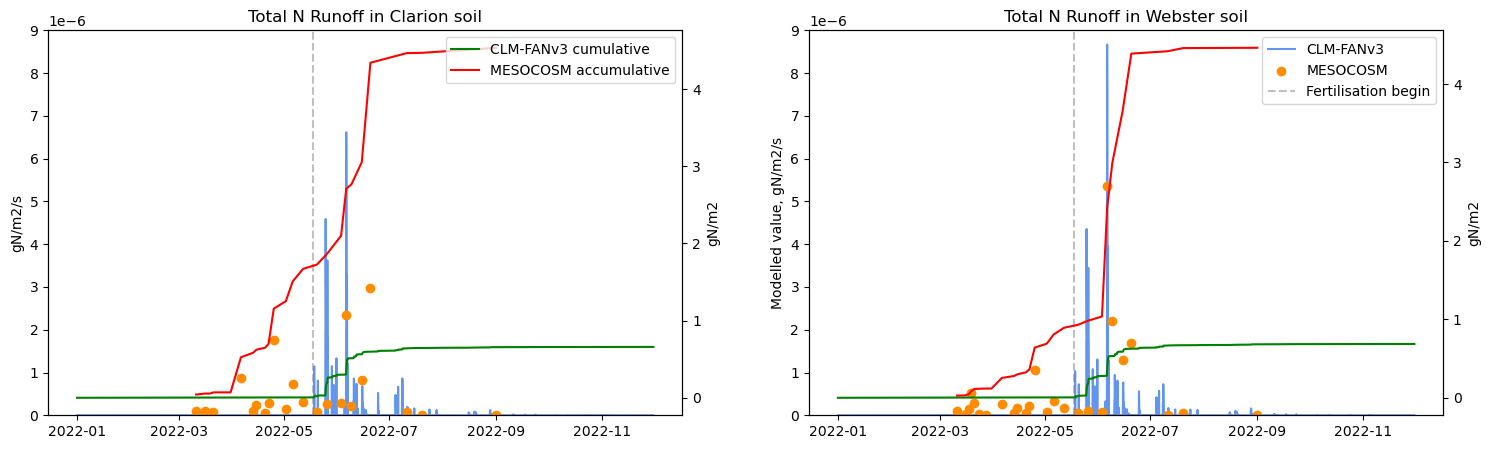

In [68]:
# Read the measuremnts
dsWater['instantaneous_drainage_nitrate_gN_m2_s'] = dsWater['instantaneous_drainage_nitrate_N_mg_L']/1000*dsWater['instantaneous_drainage_mm_s']
dsWater['instantaneous_drainage_ammonium_gN_m2_s'] = dsWater['instantaneous_drainage_ammonium_N_mg_L']/1000*dsWater['instantaneous_drainage_mm_s']
dsWater['instantaneous_drainage_nitrogen_gN_m2_s'] = dsWater['instantaneous_drainage_nitrate_gN_m2_s'] + dsWater['instantaneous_drainage_ammonium_gN_m2_s']
dsWater['cumulative_nitrogen_gN_m2'] = dsWater['cumulative_ammonium_N_yield_kg_ha']/10 + dsWater['cumulative_nitrate_N_yield_kg_ha']/10

nrunoff_cla = dsWater.loc[('Clarion', 123), 'instantaneous_drainage_nitrogen_gN_m2_s'].groupby('date').mean()
nrunoff_web = dsWater.loc[('Webster', 123), 'instantaneous_drainage_nitrogen_gN_m2_s'].groupby('date').mean()
nrunoff_cum_cla = dsWater.loc[('Clarion', 123), 'cumulative_nitrogen_gN_m2'].groupby('date').mean()
nrunoff_cum_web = dsWater.loc[('Webster', 123), 'cumulative_nitrogen_gN_m2'].groupby('date').mean()
plottime = nrunoff_cla.index.values

# CLM simulations
Total_N_runoff_cla = dsCLM_Clarion["MANURE_NITRATE_RUNOFF"] + dsCLM_Clarion['FERT_NITRATE_RUNOFF'] + dsCLM_Clarion['SMIN_NO3_RUNOFF'] + dsCLM_Clarion['SMIN_NO3_LEACHED']
Total_N_runoff_cla['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in Total_N_runoff_cla.time]
Total_N_runoff_web = dsCLM_Webster["MANURE_NITRATE_RUNOFF"] + dsCLM_Webster['FERT_NITRATE_RUNOFF'] + dsCLM_Webster['SMIN_NO3_RUNOFF'] + dsCLM_Webster['SMIN_NO3_LEACHED']
Total_N_runoff_web['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in Total_N_runoff_web.time]
## hourly resolution!!
Total_N_cum_runoff_cla = (Total_N_runoff_cla * 3600).cumsum()   
Total_N_cum_runoff_web = (Total_N_runoff_web * 3600).cumsum()

# Graph
fig, ax = plt.subplots(1, 2, figsize=(18,5))
ax0 = ax[0].twinx()
ax[0].plot(Total_N_runoff_cla.time, Total_N_runoff_cla.values, label='CLM-FANv3', color='cornflowerblue', zorder=1)
ax[0].scatter(plottime, nrunoff_cla.values, label='MESOCOSM', color='darkorange', zorder=2)
ax[0].axvline(x=fert_date, ymin=0, ymax=100,ls='--', alpha=0.5, color='grey', label='Fertilisation begin')
ax[0].set_ylim(0, 9e-6)
ax[0].set_ylabel('gN/m2/s')
ax[0].set_title('Total N Runoff in Clarion soil')
ax0.plot(Total_N_cum_runoff_cla.time, Total_N_cum_runoff_cla.values, label='CLM-FANv3 cumulative', color='green')
ax0.plot(nrunoff_cum_cla.index.values, nrunoff_cum_cla.values, label='MESOCOSM accumulative', color='red')
ax0.set_ylabel('gN/m2')
ax0.legend(loc='upper right')

ax1 = ax[1].twinx()
ax[1].plot(Total_N_runoff_web.time, Total_N_runoff_web.values, label='CLM-FANv3', color='cornflowerblue', zorder=1)
ax[1].scatter(plottime, nrunoff_web.values, label='MESOCOSM', color='darkorange', zorder=2)
ax[1].axvline(x=fert_date, ymin=0, ymax=100,ls='--', alpha=0.5, color='grey', label='Fertilisation begin')
ax[1].set_ylim(0, 9e-6)
ax[1].set_ylabel('Modelled value, gN/m2/s')
ax[1].set_title('Total N Runoff in Webster soil')
ax[1].legend(loc='upper right')
ax1.plot(Total_N_cum_runoff_web.time, Total_N_cum_runoff_web.values, label='CLM-FANv3 cumulative', color='green')
ax1.plot(nrunoff_cum_web.index.values, nrunoff_cum_web.values, label='MESOCOSM accumulative', color='red')
ax1.set_ylabel('gN/m2')

fig.savefig("graphs/Runoff_123kg.jpg", dpi=300)
plt.show()

/glade/scratch/jinmuluo/ipykernel_45212/622943942.py:12: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  plot_time = dsCLM_Clarion.indexes['time'].to_datetimeindex()


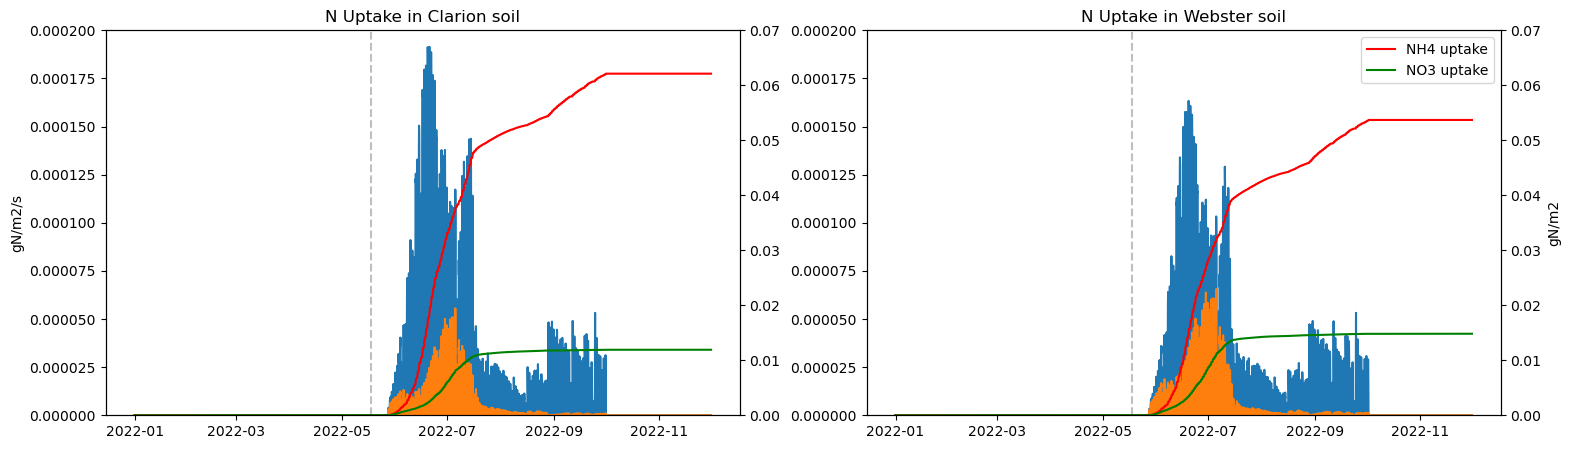

In [69]:
# CLM simulations
nh4_plant_cla = dsCLM_Clarion['SMINN_TO_PLANT_FUN_NH4'].sum(dim='levdcmp')
no3_plant_cla = dsCLM_Clarion['SMINN_TO_PLANT_FUN_NO3'].sum(dim='levdcmp')
nh4_plant_cum_cla = dsCLM_Clarion['SMINN_TO_PLANT_FUN_NH4'].sum(dim='levdcmp').cumsum()
no3_plant_cum_cla = dsCLM_Clarion['SMINN_TO_PLANT_FUN_NO3'].sum(dim='levdcmp').cumsum()

nh4_plant_web = dsCLM_Webster['SMINN_TO_PLANT_FUN_NH4'].sum(dim='levdcmp')
no3_plant_web = dsCLM_Webster['SMINN_TO_PLANT_FUN_NO3'].sum(dim='levdcmp')
nh4_plant_cum_web = dsCLM_Webster['SMINN_TO_PLANT_FUN_NH4'].sum(dim='levdcmp').cumsum()
no3_plant_cum_web = dsCLM_Webster['SMINN_TO_PLANT_FUN_NO3'].sum(dim='levdcmp').cumsum()

plot_time = dsCLM_Clarion.indexes['time'].to_datetimeindex()

# Graph
fig, ax = plt.subplots(1, 2, figsize=(18, 5))
ax0 = ax[0].twinx()
ax1 = ax[1].twinx()

ax[0].plot(plot_time, nh4_plant_cla.values, label='NH4 uptake')
ax[0].plot(plot_time, no3_plant_cla.values, label='NO3 uptake')
ax[0].axvline(x=fert_date, ymin=0, ymax=100,ls='--', alpha=0.5, color='grey', label='Planting begin')
ax[0].set_ylabel('gN/m2/s')
ax[0].set_ylim(0, 0.000200)
ax[0].set_title('N Uptake in Clarion soil')
ax0.plot(plot_time, nh4_plant_cum_cla.values, label='NH4 uptake', color='red')
ax0.plot(plot_time, no3_plant_cum_cla.values, label='NO3 uptake', color='green')
ax0.set_ylim(0, 0.07)
ax0.set_ylabel('')

ax[1].plot(plot_time, nh4_plant_web.values, label='NH4 uptake')
ax[1].plot(plot_time, no3_plant_web.values, label='NO3 uptake')
ax[1].axvline(x=fert_date, ymin=0, ymax=100,ls='--', alpha=0.5, color='grey', label='Planting begin')
ax[1].set_title('N Uptake in Webster soil')
ax[1].set_ylim(0, 0.000200)
ax1.plot(plot_time, nh4_plant_cum_web.values, label='NH4 uptake', color='red')
ax1.plot(plot_time, no3_plant_cum_web.values, label='NO3 uptake', color='green')
ax1.set_ylim(0, 0.07)
ax1.set_ylabel('gN/m2')
plt.legend()
fig.savefig("graphs/Uptake_123kg.jpg", dpi=300)
plt.show()

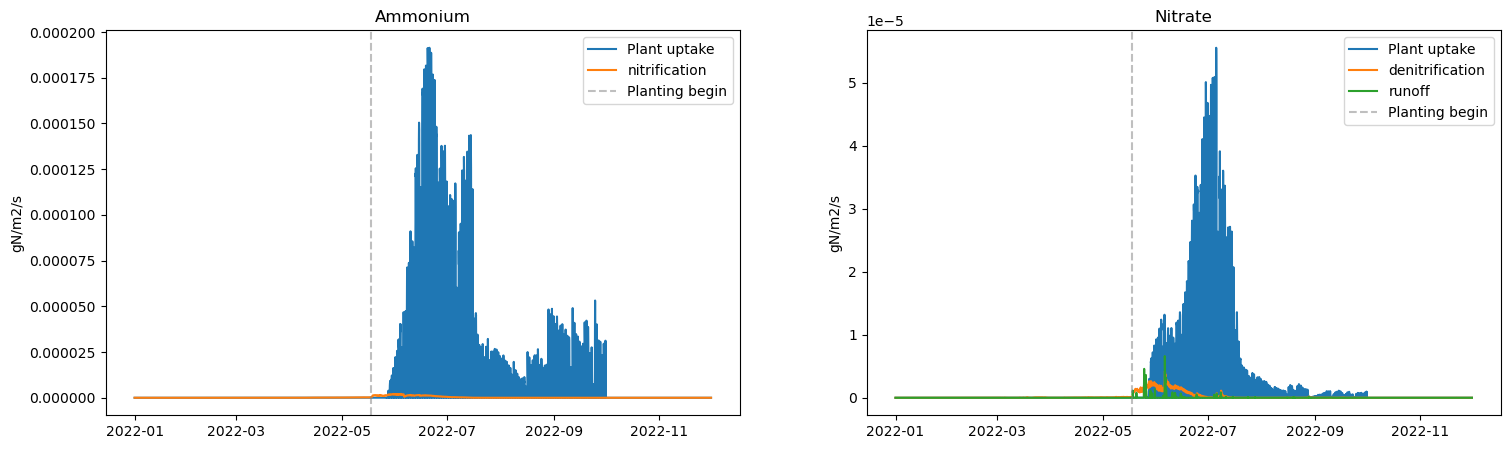

In [70]:
fig, ax = plt.subplots(1, 2, figsize=(18, 5))
ax[0].plot(plot_time, nh4_plant_cla.values, label='Plant uptake')
ax[0].plot(plot_time, dsCLM_Clarion['F_NIT'].values, label='nitrification')
ax[0].axvline(x=fert_date, ymin=0, ymax=100,ls='--', alpha=0.5, color='grey', label='Planting begin')
ax[0].set_ylabel('gN/m2/s')
ax[0].legend()
ax[0].set_title('Ammonium')

ax[1].plot(plot_time, no3_plant_cla.values, label='Plant uptake')
ax[1].plot(plot_time, dsCLM_Clarion['F_DENIT'].values, label='denitrification')
ax[1].plot(plot_time, Total_N_runoff_cla.values, label='runoff')
ax[1].axvline(x=fert_date, ymin=0, ymax=100,ls='--', alpha=0.5, color='grey', label='Planting begin')
ax[1].set_ylabel('gN/m2/s')
ax[1].set_title('Nitrate')

plt.legend()
fig.savefig("graphs/N_flows_123kg.jpg", dpi=300)
plt.show()

### 168 kgN fertilizer experiment

### 213 kgN fertilizer experiment